## Import dependecies and define fuctions

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
from scipy.optimize import curve_fit, fsolve
from scipy import interpolate

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import warnings
warnings.filterwarnings("ignore")

# install lmfit regression module
#! pip install lmfit
from lmfit.models import ConstantModel, StepModel
from lmfit import Model, Minimizer, Parameters, report_fit

## Equilibrium fuction

In [2]:
def equilibrium(time_s, elements, errors):
    results = []
    for i, j in zip(elements, errors):
    # assigne x and y values
        x = time_s
        y = df[i].to_numpy()*0.01
        y_err = df[j].to_numpy()*0.01
        #print ("\nelement", i)

        # Equilibrium concentration with 1/3 
        # A : rate_constant, to: onset of the time Ceq:eqilibrium concentraion
        # r =1/3
        r=1/3

        # define power function
        def power(x, A, Ceq):
            return A*(x)**(-r)+Ceq

        # fitting power plot with 2sigma
        popt, pcov = curve_fit(power, x, y, bounds=([-100, 0], [1000, 100]), sigma=y_err) 
        #print("Popt:", popt)
        #print("pcov: ", pcov)
        #print("A =", popt[0], "+/-", pcov[0,0]**0.5)
        #print("Ceq =", popt[1], "+/-", pcov[1,1]**0.5)
        results.append((i, "A =", round(popt[0],5), "+/-", round(pcov[0,0]**0.5,5), "Ceq =", round(popt[1],5),"+/-", round(pcov[1,1]**0.5,5)))

    print("\nEquilibrium Concentrations")
    # print stored data of equiilbrium concentration 
    print("Ceq_Al:", results[0][6], "+/-", results[0][8])
    print("Ceq_Cr:", results[1][6], "+/-", results[1][8])
    print("Ceq_Re:", results[2][6], "+/-", results[2][8])
    Ni = 1- results[0][6] - results[1][6] -results[2][6]
    Ni_err = ((results[0][8])**2 + (results[1][8])**2 + (results[2][8])**2)**0.5
    print("Ceq_Ni:", Ni,"+/-", round(Ni_err, 5))

    print("\nList(Al, Cr, Re)")
    eq_conc = [results[0][6], results[1][6], results[2][6]]
    eq_concerr = [results[0][8], results[1][8], results[2][8]]
    print(eq_conc)
    print(eq_concerr)
    return {'eq_conc':eq_conc,'eq_concerr':eq_concerr}

# Gamma (f.c.c) phase
## Import data

In [3]:
# import csv data
df0= pd.read_csv("C:/Users/jeja9/Bootcamp/APT_analysis/supersaturation\gamma_supersaturation700.csv") 
print(f"shape {df0.shape}\n")
df = df0.iloc[3:8]
df

shape (8, 10)



,time_h,time_s,G_Ni,G_Nierr,G_Al,G_Alerr,G_Cr,G_Crerr,G_Re,G_Reerr
3,4,14400,79.833756,0.081898,6.684982,0.050628,10.991558,0.063892,2.489703,0.031652
4,16,57600,79.981063,0.057273,5.935903,0.033609,11.431545,0.045644,2.651489,0.023143
5,64,230400,80.023038,0.041180,5.757687,0.024353,11.444881,0.034112,2.774394,0.016691
6,256,921600,80.077166,0.034407,5.585202,0.019892,11.554927,0.027447,2.782705,0.014183
7,1024,3686400,80.125432,0.053380,5.437891,0.030130,11.636776,0.041616,2.799900,0.021397


## Equilibrium concentrations for Gamma (f.c.c.) phase

### assign x, y, y_err

In [4]:
# Al, Cr, Re equilbrium concentration using for-loop 
#define elements and errors
time_s = df['time_s'].to_numpy()
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']

#calculate the equilibrium composition using fuction equilibrium
eq_concentration = equilibrium(time_s, elements, errors)
eq_concentration


Equilibrium Concentrations
Ceq_Al: 0.05236 +/- 0.00067
Ceq_Cr: 0.11728 +/- 0.00056
Ceq_Re: 0.02882 +/- 0.00026
Ceq_Ni: 0.80154 +/- 0.00091

List(Al, Cr, Re)
[0.05236, 0.11728, 0.02882]
[0.00067, 0.00056, 0.00026]


{'eq_conc': [0.05236, 0.11728, 0.02882],
 'eq_concerr': [0.00067, 0.00056, 0.00026]}

In [5]:
Al_eq_conc = eq_concentration['eq_conc'][0]
Al_eq_conc

0.05236

## Supersatration and fitting for Al, Cr, Re

In [6]:
# define fuction for fitting for three elements Al, Cr, Re
def fitting_value(x, y, y_err, Ceq):
    
    def power(x, A, r):
        return A*(x)**(-r)+Ceq

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([-0.5000, 0.2000], [0.5000, 0.4000]), method='trf', sigma=y_err) 
    print("\nA =", round(popt[0], 4), "+/-", pcov[0,0]**0.5)
    print("r =", round(popt[1], 4), "+/-", pcov[1,1]**0.5)
    A = round(popt[0], 4)
    r = round(popt[1], 4)

    # Calcualte the R_squared value
    best_fit = A*(x)**(-r)+Ceq
    Rsquared = round(r2_score(y, best_fit), 4)
    print(f"R_2: {Rsquared}")

    # model_fit with fine scale
    xfine = np.linspace(900, max(x), 10000) 
    f2 = A*(xfine)**(-r)+Ceq

    return {'A':A,'r':r, 'best_fit':best_fit, 'Rsquared':Rsquared, 'xfine':xfine, 'f2':f2 }

In [7]:
# Setup the element, error, and equilibrium concentration list
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
eq_conc = eq_concentration['eq_conc']
eq_concerr = eq_concentration['eq_concerr']

In [8]:
# obtain a fitting value for Al, Cr, Re using for-loop
# A : rate constant, r = exponent, Rsqure = fitting accuracy
A_list = []
r_list = []
Rsqured_list = []
bestfit_values= []
for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    
    # print the fitting values
    print ("\n", i,"_eqilibrium: ", k)
    values = fitting_value(x, y, y_err, Ceq)
    A_list.append(values['A'])
    r_list.append(values['r'])
    Rsqured_list.append(values['Rsquared'])
    bestfit_values.append(values['best_fit'])


 G_Al _eqilibrium:  0.05236

A = 0.361 +/- 0.16102805174142704
r = 0.3445 +/- 0.03937021588255043
R_2: 0.9677

 G_Cr _eqilibrium:  0.11728

A = -0.1807 +/- 0.1348838931528666
r = 0.3457 +/- 0.06656094480044322
R_2: 0.9211

 G_Re _eqilibrium:  0.02882

A = -0.1148 +/- 0.06952890731464245
r = 0.357 +/- 0.054402084333497795
R_2: 0.9651


In [9]:
# Check the value
print ("Rate_constants [Al, Cr, Re]: ",A_list)
print ("Exponents [Al, Cr, Re]: ",r_list)
print ("Rsqured values [Al, Cr, Re]: ",Rsqured_list)
print ("fit_values",bestfit_values)

Rate_constants [Al, Cr, Re]:  [0.361, -0.1807, -0.1148]
Exponents [Al, Cr, Re]:  [0.3445, 0.3457, 0.357]
Rsqured values [Al, Cr, Re]:  [0.9677, 0.9211, 0.9651]
fit_values [array([0.06569372, 0.06063069, 0.05749017, 0.05554216, 0.05433384]), array([0.110682  , 0.11319417, 0.11474984, 0.11571319, 0.11630975]), array([0.02505811, 0.02652665, 0.02742191, 0.02796768, 0.02830041])]


In [10]:
values['A']

-0.1148

In [11]:
print (values['xfine'])
print (values['f2'])

[9.00000000e+02 1.26858686e+03 1.63717372e+03 ... 3.68566283e+06
 3.68603141e+06 3.68640000e+06]
[0.01869774 0.01986519 0.02064458 ... 0.02830037 0.02830039 0.02830041]


## Plotting the experimental and model values for Al, Cr, Re


 G_Al _eqilibrium:  0.05236

A = 0.361 +/- 0.16102805174142704
r = 0.3445 +/- 0.03937021588255043
R_2: 0.9677

 G_Cr _eqilibrium:  0.11728

A = -0.1807 +/- 0.1348838931528666
r = 0.3457 +/- 0.06656094480044322
R_2: 0.9211

 G_Re _eqilibrium:  0.02882

A = -0.1148 +/- 0.06952890731464245
r = 0.357 +/- 0.054402084333497795
R_2: 0.9651


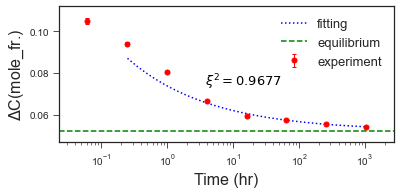

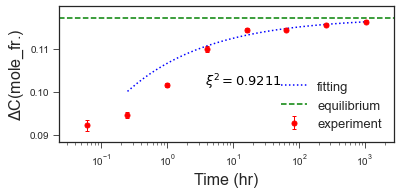

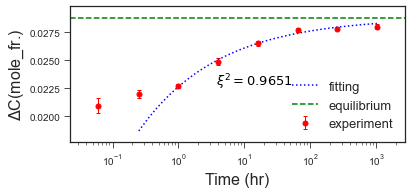

In [12]:
for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    
    # print the fitting values
    print ("\n", i,"_eqilibrium: ", k)
    values = fitting_value(x, y, y_err, Ceq)

    #time scale from second to hour
    x0b = x0/3600
    xfineb = values['xfine']/3600
    f2b = values['f2']

    #plotting
    fig, ax = plt.subplots(figsize=(6,2.5))
    ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
    ax.plot(xfineb, f2b, 'b:', label=r'fitting')
    ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
    ax.legend(loc='best', fontsize=13)
    plt.xlabel("Time (hr)", fontsize=16)
    plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
    #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
    plt.text(0.55, 0.45, r'$\xi^2={}$'.format(values['Rsquared']), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
    #plt.yscale("log")
    plt.margins(0.1)
    plt.xscale("log")



### Plot with four expoents (r) = 2, 2.4, 3, and 4

In [13]:
## define fuction for fitting_with_r values

def fitting_withr(x, y, y_err, r, Ceq):
    
    def power(x, A):
        return A*(x)**(-r)+Ceq

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([-2.000], [2.000]), method='trf', sigma=y_err) 
    print("A =", round(popt[0], 4), "+/-", pcov[0,0]**0.5)

    A = round(popt[0], 4)

    # Calcualte the R_squared value
    best_fit = A*(x)**(-r)+Ceq
    Rsquared = round(r2_score(y, best_fit), 4)
    print(f"R_2: {Rsquared}")

    # model_fit with fine scale
    xfine = np.linspace(900, max(x), 10000) 
    f2 = A*(xfine)**(-r)+Ceq

    return {'A':A, 'best_fit':best_fit,'Rsquared':Rsquared, 'xfine':xfine, 'f2':f2}



 G_Al _eqilibrium:  0.05236

Exponent value(r):  2
A = 1.9235 +/- 0.2286132703061116
R_2: 0.9145


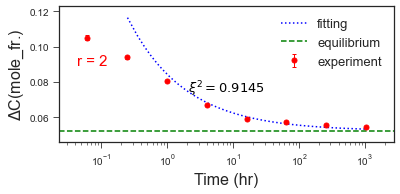


Exponent value(r):  2.4
A = 0.7983 +/- 0.05849376610411452
R_2: 0.9668


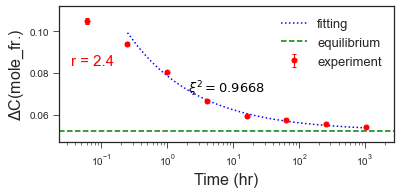


Exponent value(r):  3
A = 0.3184 +/- 0.016769972098201743
R_2: 0.9624


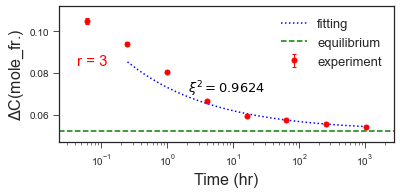


Exponent value(r):  4
A = 0.121 +/- 0.010829355317431042
R_2: 0.8594


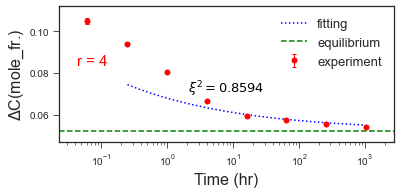



 G_Cr _eqilibrium:  0.11728

Exponent value(r):  2
A = -0.9357 +/- 0.127553437171687
R_2: 0.8961


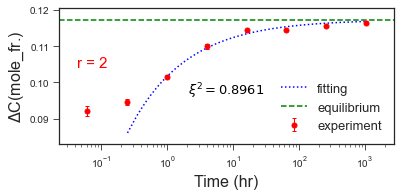


Exponent value(r):  2.4
A = -0.3912 +/- 0.03959638461015502
R_2: 0.9291


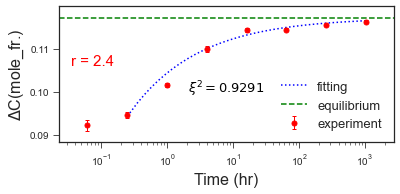


Exponent value(r):  3
A = -0.1574 +/- 0.013897709105680502
R_2: 0.9146


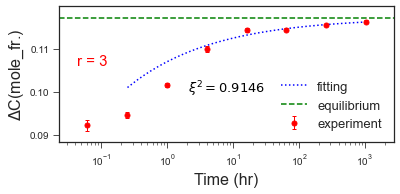


Exponent value(r):  4
A = -0.0604 +/- 0.006949171055805338
R_2: 0.8167


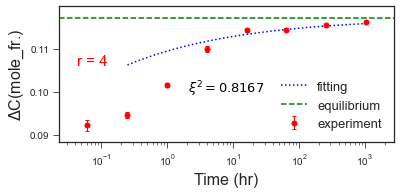



 G_Re _eqilibrium:  0.02882

Exponent value(r):  2
A = -0.5246 +/- 0.06165752032732381
R_2: 0.8962


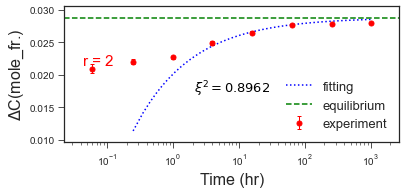


Exponent value(r):  2.4
A = -0.2192 +/- 0.017859892804166954
R_2: 0.9549


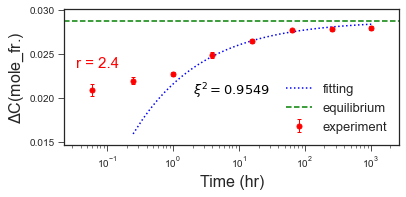


Exponent value(r):  3
A = -0.0882 +/- 0.006384002435357514
R_2: 0.9578


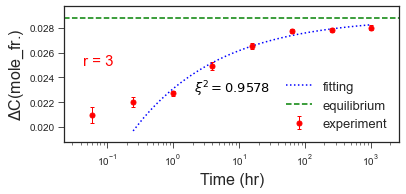


Exponent value(r):  4
A = -0.0338 +/- 0.0036158159637557363
R_2: 0.8627


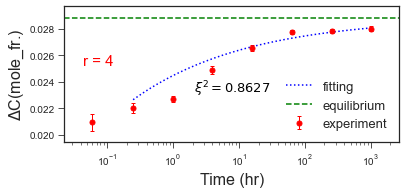

In [14]:
# for different r values ()
# Setup the element, error, and equilibrium concentration list

time_s = df['time_s'].to_numpy()
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
eq_conc = eq_concentration['eq_conc']
eq_concerr = eq_concentration['eq_concerr']


for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    print ("\n\n", i,"_eqilibrium: ", k)
    
    for n in [2, 2.4, 3, 4]:
        # print the fitting values
        print ("\nExponent value(r): ", n)
        r = 1/n
        values_wor = fitting_withr(x, y, y_err, r, Ceq)

        #time scale from second to hour
        x0b = x0/3600
        xfineb = values_wor['xfine']/3600
        f2b = values_wor['f2']
        Rsquared =values_wor['Rsquared']
        
        #plotting
        fig, ax = plt.subplots(figsize=(6,2.5))
        ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
        ax.plot(xfineb, f2b, 'b:', label=r'fitting')
        ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
        ax.legend(loc='best', fontsize=13)
        plt.xlabel("Time (hr)", fontsize=16)
        plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
        #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
        ax.text(0.1, 0.6, r'r = {}'.format(n), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
        plt.text(0.5, 0.4, r'$\xi^2={}$'.format(Rsquared), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
        #plt.yscale("log")
        plt.margins(0.1)
        plt.xscale("log")
        plt.show()
        #plt.savefig("test.png")


## Plot with exponent value of aging time



 G_Al _eqilibrium:  0.05236

Exponent value(r):  2
A = 1.9235 +/- 0.2286132703061116
R_2: 0.9145


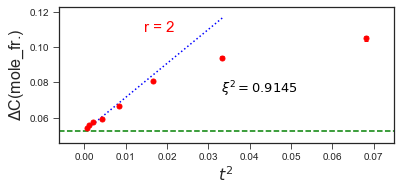


Exponent value(r):  2.4
A = 0.7983 +/- 0.05849376610411452
R_2: 0.9668


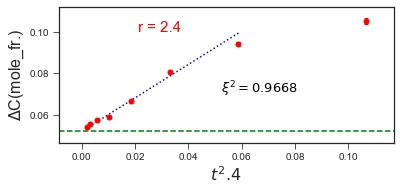


Exponent value(r):  3
A = 0.3184 +/- 0.016769972098201743
R_2: 0.9624


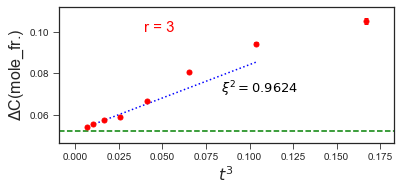


Exponent value(r):  4
A = 0.121 +/- 0.010829355317431042
R_2: 0.8594


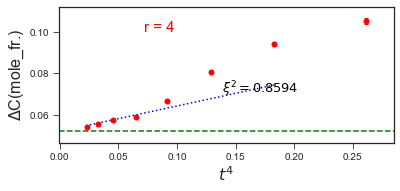



 G_Cr _eqilibrium:  0.11728

Exponent value(r):  2
A = -0.9357 +/- 0.127553437171687
R_2: 0.8961


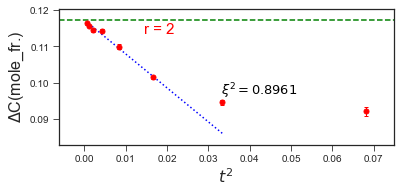


Exponent value(r):  2.4
A = -0.3912 +/- 0.03959638461015502
R_2: 0.9291


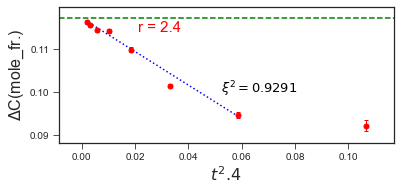


Exponent value(r):  3
A = -0.1574 +/- 0.013897709105680502
R_2: 0.9146


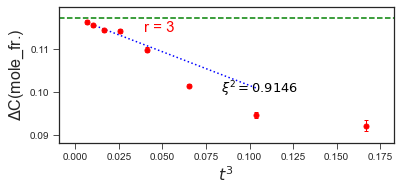


Exponent value(r):  4
A = -0.0604 +/- 0.006949171055805338
R_2: 0.8167


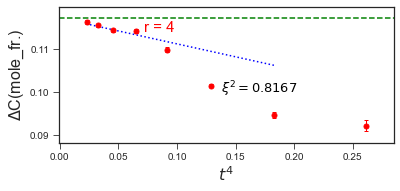



 G_Re _eqilibrium:  0.02882

Exponent value(r):  2
A = -0.5246 +/- 0.06165752032732381
R_2: 0.8962


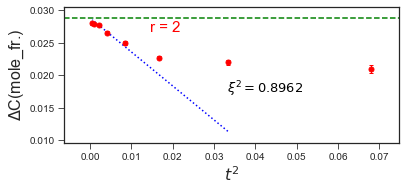


Exponent value(r):  2.4
A = -0.2192 +/- 0.017859892804166954
R_2: 0.9549


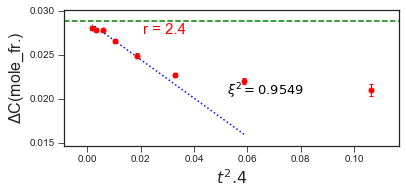


Exponent value(r):  3
A = -0.0882 +/- 0.006384002435357514
R_2: 0.9578


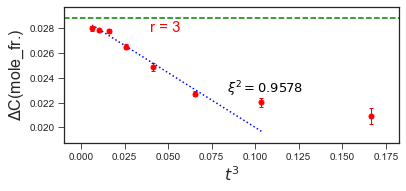


Exponent value(r):  4
A = -0.0338 +/- 0.0036158159637557363
R_2: 0.8627


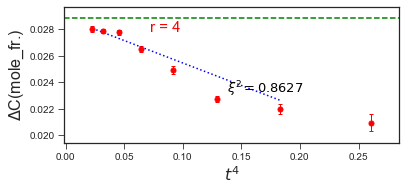

In [15]:
# for different r values ()

time_s = df['time_s'].to_numpy()
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
eq_conc = eq_concentration['eq_conc']
eq_concerr = eq_concentration['eq_concerr']

for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    print ("\n\n", i,"_eqilibrium: ", k)
    
    for n in [2, 2.4, 3, 4]:
        # print the fitting values
        print ("\nExponent value(r): ", n)
        r = 1/n
        values_wor = fitting_withr(x, y, y_err, r, Ceq)
        
        #time scale from second to hour
        x0b = x0**(-r)
        xfineb = (values_wor['xfine'])**(-r)
        f2b = values_wor['f2']
        Rsquared =values_wor['Rsquared']
        
        #plotting
        fig, ax = plt.subplots(figsize=(6,2.5))
        ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
        ax.plot(xfineb, f2b, 'b:', label=r'fitting')
        ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
        plt.xlabel(r'$t^{}$'.format(n), fontsize=16)
        plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
        #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
        ax.text(0.3, 0.85, r'r = {}'.format(n), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
        plt.text(0.6, 0.4, r'$\xi^2={}$'.format(Rsquared), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
        #plt.yscale("log")
        plt.margins(0.1)
        plt.show()
        #plt.savefig("test.png")


Exponent value(r):  2
A = 1.9235 +/- 0.2286132703061116
R_2: 0.9145

Exponent value(r):  2.4
A = 0.7983 +/- 0.05849376610411452
R_2: 0.9668

Exponent value(r):  3
A = 0.3184 +/- 0.016769972098201743
R_2: 0.9624

Exponent value(r):  4
A = 0.121 +/- 0.010829355317431042
R_2: 0.8594


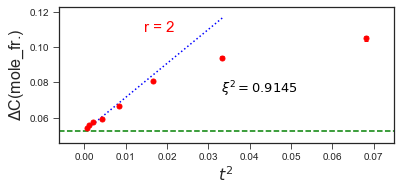

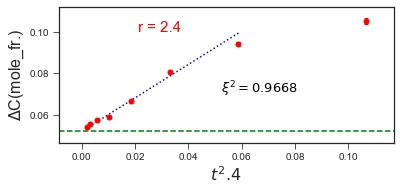

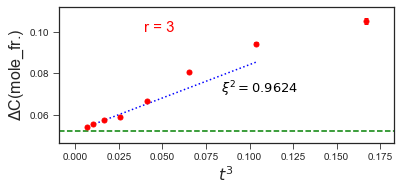

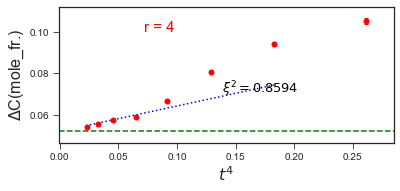

In [16]:
# for different r values ()

elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
Al_eq_conc = eq_concentration['eq_conc'][0]

x0 = df0['time_s'].to_numpy()
y0 = df0['G_Al'].to_numpy()*0.01
y0_err = df0['G_Alerr'].to_numpy()*0.01
x = df['time_s'].to_numpy()
y = df['G_Al'].to_numpy()*0.01
y_err = df['G_Alerr'].to_numpy()*0.01
Ceq = Al_eq_conc


for n in [2, 2.4, 3, 4]:
    # print the fitting values
    print ("\nExponent value(r): ", n)
    r = 1/n
    values_wor = fitting_withr(x, y, y_err, r, Ceq)

    #time scale from second to hour
    x0b = x0**(-r)
    xfineb = (values_wor['xfine'])**(-r)
    f2b = values_wor['f2']
    Rsquared =values_wor['Rsquared']

    #plotting
    fig, ax = plt.subplots(figsize=(6,2.5))
    ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
    ax.plot(xfineb, f2b, 'b:', label=r'fitting')
    ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
    plt.xlabel(r'$t^{}$'.format(n), fontsize=16)
    plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
    #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
    ax.text(0.3, 0.85, r'r = {}'.format(n), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
    plt.text(0.6, 0.4, r'$\xi^2={}$'.format(Rsquared), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
    #plt.yscale("log")
    plt.margins(0.1)
    
    #plt.savefig("test.png")

In [20]:
# define fuction for fitting for three elements Al, Cr, Re
## define fuction for fitting_with_r values

def fitting_withr(x, y, y_err, r, Ceq):
    
    def power(x, A):
        return A*(x)**(-r)+Ceq

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, sigma=y_err) 
    print("A =", round(popt[0], 4), "+/-", pcov[0,0]**0.5)

    A = round(popt[0], 4)

    # Calcualte the R_squared value
    best_fit = A*(x)**(-r)+Ceq
    Rsquared = round(r2_score(y, best_fit), 4)
    print(f"R_2: {Rsquared}")

    # model_fit with fine scale
    xfine = np.linspace(900, max(x), 10000) 
    f2 = A*(xfine)**(-r)+Ceq

    return {'A':A, 'Rsquared':Rsquared, 'xfine':xfine, 'f2':f2}

# for different r values ()

elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
Al_eq_conc = eq_concentration['eq_conc'][0]

x0 = df0['time_s'].to_numpy()
y0 = df0['G_Al'].to_numpy()*0.01
y0_err = df0['G_Alerr'].to_numpy()*0.01
x = df['time_s'].to_numpy()
y = df['G_Al'].to_numpy()*0.01
y_err = df['G_Alerr'].to_numpy()*0.01
Ceq = Al_eq_conc

rsq_dict ={}

for n in np.linspace(1.5, 4, 1000):
    # print the fitting values
    print ("\nExponent value(r): ", n)
    r = 1/n
    values_wor = fitting_withr(x, y, y_err, r, Ceq)

    #time scale from second to hour
    x0b = x0**(-r)
    xfineb = (values_wor['xfine'])**(-r)
    f2b = values_wor['f2']
    Rsquared =values_wor['Rsquared']
    rsq_dict[n] =values_wor['Rsquared']

print (rsq_dict)


Exponent value(r):  1.5
A = 10.277 +/- 2.161429437035173
R_2: 0.7602

Exponent value(r):  1.5025025025025025
A = 10.1655 +/- 2.1322044549065975
R_2: 0.7612

Exponent value(r):  1.505005005005005
A = 10.0557 +/- 2.103442489957968
R_2: 0.7622

Exponent value(r):  1.5075075075075075
A = 9.9473 +/- 2.0751349525847402
R_2: 0.7633

Exponent value(r):  1.51001001001001
A = 9.8404 +/- 2.0472737775321797
R_2: 0.7643

Exponent value(r):  1.5125125125125125
A = 9.735 +/- 2.0198506334480513
R_2: 0.7653

Exponent value(r):  1.515015015015015
A = 9.6311 +/- 1.9928578478893888
R_2: 0.7663

Exponent value(r):  1.5175175175175175
A = 9.5285 +/- 1.9662874012598806
R_2: 0.7674

Exponent value(r):  1.52002002002002
A = 9.4274 +/- 1.9401318791459063
R_2: 0.7684

Exponent value(r):  1.5225225225225225
A = 9.3276 +/- 1.914383710287007
R_2: 0.7694

Exponent value(r):  1.525025025025025
A = 9.2292 +/- 1.8890355626749118
R_2: 0.7704

Exponent value(r):  1.5275275275275275
A = 9.1322 +/- 1.8640804595315814
R_2:


Exponent value(r):  2.0355355355355353
A = 1.757 +/- 0.2000694833623733
R_2: 0.9215

Exponent value(r):  2.038038038038038
A = 1.746 +/- 0.19821845638721472
R_2: 0.922

Exponent value(r):  2.0405405405405403
A = 1.7351 +/- 0.19638701335653735
R_2: 0.9224

Exponent value(r):  2.043043043043043
A = 1.7243 +/- 0.1945749237834125
R_2: 0.9229

Exponent value(r):  2.0455455455455454
A = 1.7136 +/- 0.19278197066509087
R_2: 0.9234

Exponent value(r):  2.048048048048048
A = 1.703 +/- 0.19100792882971837
R_2: 0.9238

Exponent value(r):  2.0505505505505504
A = 1.6925 +/- 0.18925254801589111
R_2: 0.9243

Exponent value(r):  2.053053053053053
A = 1.6821 +/- 0.18751563595038911
R_2: 0.9247

Exponent value(r):  2.0555555555555554
A = 1.6717 +/- 0.1857969389995689
R_2: 0.9252

Exponent value(r):  2.058058058058058
A = 1.6614 +/- 0.184096284259303
R_2: 0.9257

Exponent value(r):  2.0605605605605604
A = 1.6513 +/- 0.18241342754735898
R_2: 0.9261

Exponent value(r):  2.063063063063063
A = 1.6412 +/- 0.1


Exponent value(r):  2.3133133133133135
A = 0.9438 +/- 0.07661458949909114
R_2: 0.9601

Exponent value(r):  2.315815815815816
A = 0.9391 +/- 0.07600409704526764
R_2: 0.9603

Exponent value(r):  2.3183183183183185
A = 0.9345 +/- 0.07539937482970646
R_2: 0.9605

Exponent value(r):  2.320820820820821
A = 0.9298 +/- 0.07480036720173251
R_2: 0.9608

Exponent value(r):  2.3233233233233235
A = 0.9252 +/- 0.07420701704567882
R_2: 0.961

Exponent value(r):  2.325825825825826
A = 0.9207 +/- 0.07361926306639574
R_2: 0.9612

Exponent value(r):  2.3283283283283285
A = 0.9161 +/- 0.07303705719262599
R_2: 0.9614

Exponent value(r):  2.330830830830831
A = 0.9116 +/- 0.07246033669565428
R_2: 0.9616

Exponent value(r):  2.3333333333333335
A = 0.9071 +/- 0.07188905294607496
R_2: 0.9619

Exponent value(r):  2.335835835835836
A = 0.9027 +/- 0.07132314750074993
R_2: 0.9621

Exponent value(r):  2.3383383383383385
A = 0.8983 +/- 0.07076256802793877
R_2: 0.9623

Exponent value(r):  2.340840840840841
A = 0.8939


Exponent value(r):  2.611111111111111
A = 0.5534 +/- 0.03268276272825967
R_2: 0.9742

Exponent value(r):  2.6136136136136137
A = 0.5512 +/- 0.03248344480167452
R_2: 0.9742

Exponent value(r):  2.616116116116116
A = 0.549 +/- 0.03228602237466302
R_2: 0.9742

Exponent value(r):  2.6186186186186187
A = 0.5468 +/- 0.032090483293834876
R_2: 0.9742

Exponent value(r):  2.621121121121121
A = 0.5446 +/- 0.03189680562868228
R_2: 0.9742

Exponent value(r):  2.6236236236236237
A = 0.5425 +/- 0.03170497904565044
R_2: 0.9743

Exponent value(r):  2.626126126126126
A = 0.5403 +/- 0.03151498034180591
R_2: 0.9743

Exponent value(r):  2.6286286286286287
A = 0.5381 +/- 0.031326798700625325
R_2: 0.9743

Exponent value(r):  2.631131131131131
A = 0.536 +/- 0.031140415972665293
R_2: 0.9743

Exponent value(r):  2.6336336336336337
A = 0.5339 +/- 0.030955815807416177
R_2: 0.9743

Exponent value(r):  2.636136136136136
A = 0.5318 +/- 0.030772984007448705
R_2: 0.9743

Exponent value(r):  2.6386386386386387
A = 0.


Exponent value(r):  2.9014014014014013
A = 0.3617 +/- 0.01881534812672655
R_2: 0.9678

Exponent value(r):  2.903903903903904
A = 0.3605 +/- 0.018752679251767074
R_2: 0.9677

Exponent value(r):  2.9064064064064064
A = 0.3593 +/- 0.018690647261778506
R_2: 0.9676

Exponent value(r):  2.908908908908909
A = 0.3581 +/- 0.018629245527260203
R_2: 0.9675

Exponent value(r):  2.9114114114114114
A = 0.3569 +/- 0.018568468083866495
R_2: 0.9673

Exponent value(r):  2.913913913913914
A = 0.3558 +/- 0.018508307961451233
R_2: 0.9672

Exponent value(r):  2.9164164164164164
A = 0.3546 +/- 0.01844875758621357
R_2: 0.9671

Exponent value(r):  2.918918918918919
A = 0.3534 +/- 0.018389813712152096
R_2: 0.967

Exponent value(r):  2.9214214214214214
A = 0.3523 +/- 0.01833146654034606
R_2: 0.9669

Exponent value(r):  2.923923923923924
A = 0.3511 +/- 0.01827371145115853
R_2: 0.9667

Exponent value(r):  2.9264264264264264
A = 0.3499 +/- 0.018216542416651153
R_2: 0.9666

Exponent value(r):  2.928928928928929
A =


Exponent value(r):  3.191691691691692
A = 0.2536 +/- 0.014458064749645325
R_2: 0.9482

Exponent value(r):  3.1941941941941945
A = 0.2528 +/- 0.014436891474128329
R_2: 0.9479

Exponent value(r):  3.196696696696697
A = 0.2521 +/- 0.014415880664820458
R_2: 0.9477

Exponent value(r):  3.1991991991991995
A = 0.2514 +/- 0.014395031466016174
R_2: 0.9475

Exponent value(r):  3.201701701701702
A = 0.2507 +/- 0.014374341720284924
R_2: 0.9473

Exponent value(r):  3.2042042042042045
A = 0.25 +/- 0.014353808793549612
R_2: 0.947

Exponent value(r):  3.206706706706707
A = 0.2493 +/- 0.014333431556418768
R_2: 0.9468

Exponent value(r):  3.2092092092092095
A = 0.2486 +/- 0.014313207477078276
R_2: 0.9466

Exponent value(r):  3.211711711711712
A = 0.2479 +/- 0.014293134722753682
R_2: 0.9464

Exponent value(r):  3.2142142142142145
A = 0.2473 +/- 0.014273211315056235
R_2: 0.9463

Exponent value(r):  3.216716716716717
A = 0.2466 +/- 0.014253435365259285
R_2: 0.946

Exponent value(r):  3.2192192192192195
A 


Exponent value(r):  3.471971971971972
A = 0.1894 +/- 0.012756420928405303
R_2: 0.9212

Exponent value(r):  3.4744744744744747
A = 0.1889 +/- 0.012745040691240765
R_2: 0.9208

Exponent value(r):  3.476976976976977
A = 0.1885 +/- 0.012733700062668996
R_2: 0.9206

Exponent value(r):  3.4794794794794797
A = 0.188 +/- 0.01272239819474031
R_2: 0.9203

Exponent value(r):  3.481981981981982
A = 0.1876 +/- 0.012711135861966733
R_2: 0.9201

Exponent value(r):  3.4844844844844847
A = 0.1871 +/- 0.012699910859575277
R_2: 0.9197

Exponent value(r):  3.486986986986987
A = 0.1867 +/- 0.012688723696625787
R_2: 0.9196

Exponent value(r):  3.4894894894894897
A = 0.1862 +/- 0.012677573915224664
R_2: 0.9192

Exponent value(r):  3.491991991991992
A = 0.1858 +/- 0.01266646070211599
R_2: 0.919

Exponent value(r):  3.4944944944944947
A = 0.1853 +/- 0.012655384006279718
R_2: 0.9186

Exponent value(r):  3.496996996996997
A = 0.1849 +/- 0.012644343270016917
R_2: 0.9185

Exponent value(r):  3.4994994994994997
A 

A = 0.1454 +/- 0.011598135880635116
R_2: 0.8878

Exponent value(r):  3.76976976976977
A = 0.1451 +/- 0.011589389857267516
R_2: 0.8875

Exponent value(r):  3.7722722722722724
A = 0.1448 +/- 0.011580656675990054
R_2: 0.8872

Exponent value(r):  3.774774774774775
A = 0.1445 +/- 0.011571935637888851
R_2: 0.887

Exponent value(r):  3.7772772772772774
A = 0.1442 +/- 0.011563226970672507
R_2: 0.8867

Exponent value(r):  3.77977977977978
A = 0.1439 +/- 0.011554529898720472
R_2: 0.8863

Exponent value(r):  3.7822822822822824
A = 0.1436 +/- 0.011545845151668992
R_2: 0.886

Exponent value(r):  3.784784784784785
A = 0.1433 +/- 0.011537172151794095
R_2: 0.8857

Exponent value(r):  3.7872872872872874
A = 0.143 +/- 0.011528511092155204
R_2: 0.8854

Exponent value(r):  3.78978978978979
A = 0.1427 +/- 0.011519861172681257
R_2: 0.8851

Exponent value(r):  3.7922922922922924
A = 0.1424 +/- 0.011511223343000202
R_2: 0.8848

Exponent value(r):  3.794794794794795
A = 0.1421 +/- 0.011502597448575883
R_2: 0.8

In [21]:
fit_df=pd.DataFrame.from_dict(rsq_dict, orient='index',
                       columns=['Rsquared'])
print(fit_df["Rsquared"].max())
print(fit_df["Rsquared"].idxmax())
print(1/fit_df["Rsquared"].idxmax())

0.9743
2.6236236236236237
0.38115223197252956


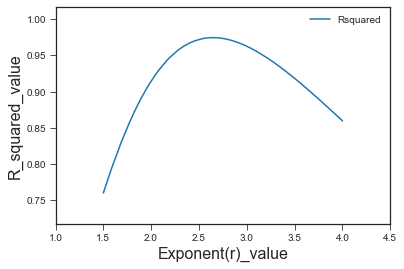

In [22]:
fit_df.plot(y='Rsquared', kind = 'line')
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "R_squared_value", fontsize=16)
plt.margins(0.2)
plt.show()